<a href="https://colab.research.google.com/github/mrrkdas/Mini-Projects/blob/main/Transfer_Learning_with_tf_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading in the data
split = ['train[:70%]', 'train[70%:]']
train_data, test_data = tfds.load(name = 'tf_flowers', split = split, as_supervised = True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


## Getting to know the data

In [3]:
# Defining the Classes
classes = ['Dandelion', 'Daisy', 'Tulips', 'Sunflower', 'Rose']

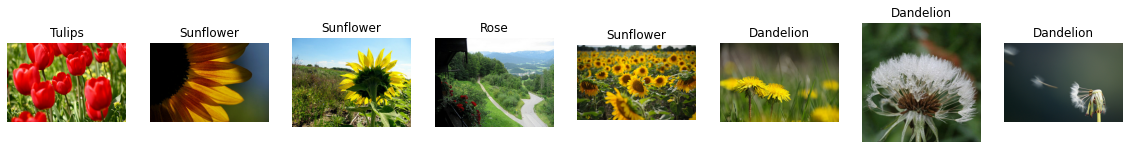

In [4]:
i = 0
fig, ax = plt.subplots(1, 8, figsize = (20, 20))
for image, label in train_data.take(8): 
    ax[i].axis('off')
    ax[i].set_title(classes[label])
    ax[i].imshow(image)
    i += 1
 
plt.show()

## Preprocessing

In [5]:
def preprocess_images(img, label, height = 260, width = 260): 
  """ This function resizes the images, and return the label along with the image

  Parameters:
      height: the height to reisize the image
      width: the width to resize the image """ 

  image  = tf.image.resize(img, [height, width]) / 255 # Resizing and making the image standardized

  return image, label

In [6]:
# Defining height and width
HEIGHT = 260
WIDTH = 260

In [7]:
train_data = train_data.map(preprocess_images).batch(64).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_images).batch(64).prefetch(tf.data.AUTOTUNE)

In [8]:
# Data Augmentation 
# batch_size = 64
# data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.3, 
                                                                 #horizontal_flip = True, vertical_flip = True, zoom_range = 0.3)
# train_generator = data_generator.flow(train_data, batch_size = batch_size)
# steps_per_epoch = (len(train_data)) // batch_size
# Getting a type error

## Model using efficient_net_v2

In [9]:
# Getting the URL
efficientnet_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/classification/2'

In [10]:
# Defining if we want to fine tune or not
fine_tuning = False

In [11]:
feature_extractor_layer = hub.KerasLayer(efficientnet_url, 
                                         trainable = fine_tuning, # Freezing the parameters
                                         input_shape = (HEIGHT, WIDTH) + (3,), 
                                         name = 'feature_extractor_layer')

In [12]:
# Creating the model
efficientnet_model = tf.keras.Sequential([
                                          feature_extractor_layer,
                                          tf.keras.layers.Dense(5, activation = 'softmax', name = 'output_layer'),
                                          #name = 'efficientnet_model' 
                                          ], name = 'efficientnet_model')

In [13]:
# Compiling the model
efficientnet_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['sparse_categorical_accuracy'])

In [14]:
efficientnet_history = efficientnet_model.fit(train_data, epochs = 5, validation_data = test_data)

Epoch 1/5
41/41 [==============================] - 45s 607ms/step - loss: 0.9841 - sparse_categorical_accuracy: 0.6458 - val_loss: 0.5592 - val_sparse_categorical_accuracy: 0.7866
Epoch 2/5
41/41 [==============================] - 25s 624ms/step - loss: 0.4559 - sparse_categorical_accuracy: 0.8400 - val_loss: 0.4439 - val_sparse_categorical_accuracy: 0.8347
Epoch 3/5
41/41 [==============================] - 22s 532ms/step - loss: 0.3761 - sparse_categorical_accuracy: 0.8700 - val_loss: 0.3949 - val_sparse_categorical_accuracy: 0.8619
Epoch 4/5
41/41 [==============================] - 26s 628ms/step - loss: 0.3324 - sparse_categorical_accuracy: 0.8933 - val_loss: 0.3691 - val_sparse_categorical_accuracy: 0.8701
Epoch 5/5
41/41 [==============================] - 22s 537ms/step - loss: 0.3028 - sparse_categorical_accuracy: 0.9039 - val_loss: 0.3527 - val_sparse_categorical_accuracy: 0.8756


## After Model

In [15]:
def plot_metrics(history, accuracy = 'accuracy', validation_accuracy = 'val_accuracy'):
  """ Plots loss, and accuracy. 

  Parameter:

    history: model.fit()
    accuracy: the type of accuracy (could vary for sum situations)
    validation_accuracy: type of validation accuracy (could vary for some situations) """

  plt.plot(history.history['loss'], label = "Loss")
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Vs. Epochs')
  plt.legend()
  plt.show()

  plt.plot(history.history[accuracy], label = "Accuracy")
  plt.plot(history.history[validation_accuracy], label = 'Validation Accuracy')
  plt.xlabel('Epcohs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Vs. Epochs')
  plt.legend()
  plt.show()

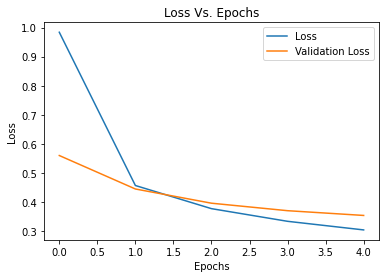

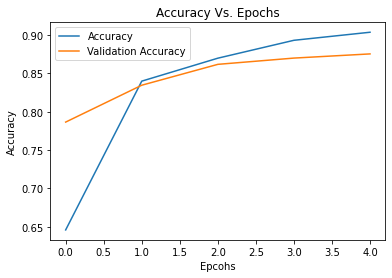

In [16]:
plot_metrics(efficientnet_history, accuracy = 'sparse_categorical_accuracy', validation_accuracy = 'val_sparse_categorical_accuracy')

In [17]:
# Evaluate
efficientnet_results = efficientnet_model.evaluate(test_data)

18/18 [==============================] - 7s 365ms/step - loss: 0.3527 - sparse_categorical_accuracy: 0.8756


In [18]:
# Predictions
preds = efficientnet_model.predict(test_data)

In [19]:
preds = np.round_(preds)

In [20]:
test_data_unbatched = test_data.unbatch()

In [21]:
images = []
labels = []

for image, label in test_data_unbatched:
  images.append(image)
  labels.append(label)

In [25]:
preds

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

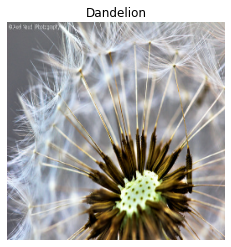

In [26]:
plt.imshow(images[1])
plt.title(classes[preds[1].argmax()])
plt.axis('off')
plt.show()

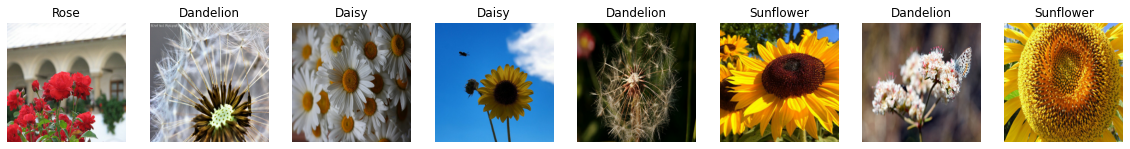

In [29]:
i = 0
fig, ax = plt.subplots(1, 8, figsize = (20, 20))
for image, label in test_data_unbatched.take(8):
    ax[i].axis('off')
    ax[i].set_title(classes[preds[i].argmax()])
    # ax[i].s
    ax[i].imshow(image)
    i += 1
 
plt.show()